In [1]:
%matplotlib inline

import csv
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import roc_curve

# Check how diverse is the data set.

In [2]:
def parse_dict(d):
    user_tags = d['user_tags'].split(',')
    del d['user_tags']
    for tag in user_tags:
        d['tag_' + tag] = True
    del d['click']  # Click is the target variable.
    return d

In [3]:
field_names = ['click', 'weekday', 'hour', 'timestamp', 'log_type', 'user_id', 'user_agent',
               'ip', 'region', 'city', 'ad_exchange', 'domain', 'url', 'anonymous_url_id', 
               'ad_slot_id', 'ad_slot_width', 'ad_slot_height', 'ad_slot_visibility', 'ad_slot_format',
               'ad_slot_floor_price', 'creative_id', 'key_page_url', 'advertiser_id', 'user_tags']
l = []
with open('train.txt') as f:
    reader = csv.DictReader(f, delimiter='\t', fieldnames=field_names)
    for row in reader:
        d = parse_dict(row)
        l.append(d)
        if len(l) > 100000:
            break

In [4]:
set_keys = set()
for d in l:
    for key in d:
        set_keys.add(key)

In [5]:
for key in sorted(set_keys):
    if key.startswith('tag_'):
        continue
    print(key, len(set([x[key] for x in l if key in x])))

ad_exchange 3
ad_slot_floor_price 92
ad_slot_format 3
ad_slot_height 6
ad_slot_id 7135
ad_slot_visibility 4
ad_slot_width 11
advertiser_id 1
anonymous_url_id 1
city 368
creative_id 11
domain 3475
hour 11
ip 65488
key_page_url 2
log_type 1
region 35
timestamp 90971
url 35194
user_agent 31
user_id 90574
weekday 1


As result of this, we choose, as a start, to throw out `ip`, `user_id`, `url`, `timestamp`, `domain`, `city`, `ad_slot_id` fields as they would lead to too many features.
Also remove fields that have no diversity, like `advertiser_id` and `log_type`.

# Convert dataset into encoded features

In [18]:
float_fields = ['ad_slot_floor_price', 'ad_slot_height', 'ad_slot_width', 'hour']
remove_fields = ['ip', 'user_id', 'url', 'timestamp', 'domain', 'city', 'ad_slot_id', 'log_type', 'advertiser_id', 'anonymous_url_id']
def parse_dict(d):
    user_tags = d['user_tags'].split(',')
    del d['user_tags']
    for tag in user_tags:
        d['tag_' + tag] = True
    if 'click' in d:
        del d['click']  # Click is the target variable.
    for ff in float_fields:
        d[ff] = float(d[ff])
    for f in remove_fields:
        del d[f]
    user_agent = d['user_agent']
    os, browser = user_agent.split('_')
    d['os'] = os
    d['browser'] = browser
    del d['user_agent']
    return d

In [7]:
# Use first million data points to train the DictVectorizer.
l = []
with open('train.txt') as f:
    reader = csv.DictReader(f, delimiter='\t', fieldnames=field_names)
    for row in reader:
        d = parse_dict(row)
        l.append(d)
        if len(l) == 1000000:
            break

In [8]:
dv = DictVectorizer()

In [9]:
dv.fit(l)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)

In [10]:
# Check what features we have.
print(len(dv.get_feature_names()))
dv.get_feature_names()

124


['ad_exchange=1',
 'ad_exchange=2',
 'ad_exchange=3',
 'ad_slot_floor_price',
 'ad_slot_format=0',
 'ad_slot_format=1',
 'ad_slot_format=5',
 'ad_slot_height',
 'ad_slot_visibility=0',
 'ad_slot_visibility=1',
 'ad_slot_visibility=2',
 'ad_slot_visibility=255',
 'ad_slot_width',
 'browser=chrome',
 'browser=firefox',
 'browser=ie',
 'browser=maxthon',
 'browser=opera',
 'browser=other',
 'browser=safari',
 'browser=sogou',
 'browser=theworld',
 'creative_id=011c1a3d4d3f089a54f9b70a4c0a6eb3',
 'creative_id=2f88fc9cf0141b5bbaf251cab07f4ce7',
 'creative_id=44966cc8da1ed40c95d59e863c8c75f0',
 'creative_id=47905feeb59223468fb898b3c9ac024d',
 'creative_id=6cdf8fdd3e01122b09b5b411510a2385',
 'creative_id=7097e4210dea4d69f07f0f5e4343529c',
 'creative_id=82f125e356439d73902ae85e2be96777',
 'creative_id=86c2543527c86a893d4d4f68810a0416',
 'creative_id=b90c12ed2bd7950c6027bf9c6937c48a',
 'creative_id=e87d7633d474589c2e2e3ba4eda53f6c',
 'creative_id=ff5123fb9333ca095034c62fdaaf51aa',
 'hour',
 'ke

# Transform data into features on the fly

In [11]:
# At this point we are ready to transform the data into features.
field_names = ['click', 'weekday', 'hour', 'timestamp', 'log_type', 'user_id', 'user_agent',
               'ip', 'region', 'city', 'ad_exchange', 'domain', 'url', 'anonymous_url_id', 
               'ad_slot_id', 'ad_slot_width', 'ad_slot_height', 'ad_slot_visibility', 'ad_slot_format',
               'ad_slot_floor_price', 'creative_id', 'key_page_url', 'advertiser_id', 'user_tags']
def stream_data(test_data=False, train_data=False):
    l = []
    targets = []
    with open('train.txt') as f:
        reader = csv.DictReader(f, delimiter='\t', fieldnames=field_names)
        for n, row in enumerate(reader):
            n += 1
            if not train_data and n <= 2000000:
                continue
            if not test_data and n > 2000000:
                continue
            targets.append(int(row['click']))
            d = parse_dict(row)
            l.append(d)
            if len(l) == 5000:
                features = dv.transform(l).toarray()
                yield features, np.array(targets, dtype='int16')
                l = []
                targets = []
        if len(l) > 0:
            features = dv.transform(l).toarray()
            yield features, np.array(targets, dtype='int16')

In [12]:
def MySGDClassifier(alpha):
    return SGDClassifier(loss='log', n_iter=5, warm_start=True, alpha=alpha)
predictors = [BernoulliNB(), MultinomialNB(), GaussianNB(), MySGDClassifier(alpha=0.1), MySGDClassifier(alpha=1), MySGDClassifier(alpha=10), MySGDClassifier(alpha=100)]
n = 0
classes = [0, 1]
for features, targets in stream_data(train_data=True):
    n += 1
    for pred in predictors:
        pred.partial_fit(features, targets, classes=classes)
    if n % 50 == 0:
        print(n)

50
100
150
200
250
300
350
400


In [13]:
n = 0
total_predictions = [ [], [], [], [], [], [], [] ]
total_targets = np.zeros(0, dtype='int16')
for features, targets in stream_data(test_data=True):
    total_targets = np.append(total_targets, targets)
    for i, pred in enumerate(predictors):
        probas = pred.predict_log_proba(features)[:,1]
        total_predictions[i] = np.append(total_predictions[i], probas)
    n += 1
    if n % 50 == 0:
        print(n)

50
100
150


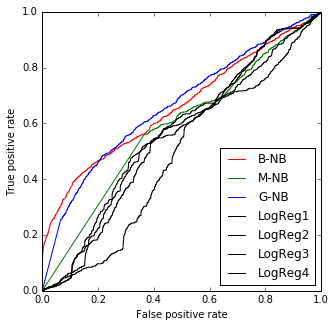

In [14]:
colors = ['r', 'g', 'b', 'k', 'k', 'k', 'k']
labels = ['B-NB', 'M-NB', 'G-NB', 'LogReg1', 'LogReg2', 'LogReg3', 'LogReg4']
plt.figure(figsize=(5, 5))
for i in range(7):
    fpr, tpr, thresholds = roc_curve(total_targets, total_predictions[i])
    plt.plot(fpr, tpr, colors[i], label=labels[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right');


# Choose 1 predictor, train up with full data and predict the test data

In [15]:
predictor = GaussianNB()
n = 0
classes = [0, 1]
for features, targets in stream_data(train_data=True, test_data=True):
    n += 1
    predictor.partial_fit(features, targets, classes=classes)
    if n % 50 == 0:
        print(n)

50
100
150
200
250
300
350
400
450
500
550


In [16]:
# Load test data.
test_field_names = ['weekday', 'hour', 'timestamp', 'log_type', 'user_id', 'user_agent',
               'ip', 'region', 'city', 'ad_exchange', 'domain', 'url', 'anonymous_url_id', 
               'ad_slot_id', 'ad_slot_width', 'ad_slot_height', 'ad_slot_visibility', 'ad_slot_format',
               'ad_slot_floor_price', 'creative_id', 'key_page_url', 'advertiser_id', 'user_tags']
def stream_test_data():
    l = []
    with open('test.txt') as f:
        reader = csv.DictReader(f, delimiter='\t', fieldnames=test_field_names)
        for n, row in enumerate(reader):
            d = parse_dict(row)
            l.append(d)
            if len(l) == 5000:
                features = dv.transform(l).toarray()
                yield features
                l = []
        if len(l) > 0:
            features = dv.transform(l).toarray()
            yield features

In [24]:
n = 1
with open('submission.csv', 'w') as f:
    f.write('Id,Prediction\n')
    for features in stream_test_data():
        for row in predictor.predict_proba(features):
            f.write('%d,%.4f\n' % (n, row[1]))
            n += 1